In [7]:
import logging
import os
import sys
import shutil
import tempfile

import matplotlib.pyplot as plt
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np

import monai
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import DataLoader, ImageDataset
from monai.transforms import (
    EnsureChannelFirst,
    Compose,
    RandRotate90,
    Resize,
    ScaleIntensity,
)

pin_memory = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Using CPU/GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
print_config()

Using device: cuda
Using CPU/GPU: NVIDIA GeForce RTX 4070 Laptop GPU
MONAI version: 1.5.2
Numpy version: 2.4.2
Pytorch version: 2.10.0+cu126
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: d18565fb3e4fd8c556707f91ac280a2dc3f681c1
MONAI __file__: c:\Users\<username>\GitHub\ADHD-MRI-Deep-Learning\ADHD_DL_VENV\Lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.3
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: 1.17.0
Pillow version: 12.1.1
Tensorboard version: 2.20.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.25.0+cu126
tqdm version: 4.67.3
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 7.2.2
pandas version: 3.0.0
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or

In [1]:
import os
import pandas as pd
import torch

bids_root = r"C:\Users\janak\GitHub\ADHD-MRI-Deep-Learning\ADHD_BIDS"

# Read participant labels
participants = pd.read_csv(os.path.join(bids_root, "participants.tsv"), sep="\t")

# Create lists of file paths and labels
images = []
labels = []

for idx, row in participants.iterrows():
    sub_id = row['participant_id']
    label = row['label']  # ADHD=1, Control=0
    img_path = os.path.join(bids_root, ("sub-" + str(sub_id)), "anat", f"{sub_id}_T1w.nii.gz")
    if os.path.isfile(img_path):
        images.append(img_path)
        labels.append(label)

# Convert labels to one-hot encoding
labels = torch.nn.functional.one_hot(torch.as_tensor(labels)).float()
print(f"Found {len(images)} images")

Found 896 images


In [3]:
from monai.transforms import Compose, ScaleIntensity, EnsureChannelFirst, Resize, RandRotate90

train_transforms = Compose([
    ScaleIntensity(),
    EnsureChannelFirst(),
    Resize((96, 96, 96)),
    RandRotate90()  # optional data augmentation
])

val_transforms = Compose([
    ScaleIntensity(),
    EnsureChannelFirst(),
    Resize((96, 96, 96))
])


In [4]:
from monai.data import ImageDataset, DataLoader

# Example: first 80% train, last 20% validation
split = int(0.8 * len(images))
train_ds = ImageDataset(image_files=images[:split], labels=labels[:split], transform=train_transforms)
val_ds = ImageDataset(image_files=images[split:], labels=labels[split:], transform=val_transforms)

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())
val_loader = DataLoader(val_ds, batch_size=2, num_workers=2, pin_memory=torch.cuda.is_available())

In [8]:
# Create DenseNet121, CrossEntropyLoss and Adam optimizer
model = monai.networks.nets.DenseNet121(spatial_dims=3, in_channels=1, out_channels=2).to(device)

loss_function = torch.nn.CrossEntropyLoss()
# loss_function = torch.nn.BCEWithLogitsLoss()  # also works with this data

optimizer = torch.optim.Adam(model.parameters(), 1e-4)

# start a typical PyTorch training
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()
max_epochs = 5

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0

    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()

        num_correct = 0.0
        metric_count = 0
        for val_data in val_loader:
            val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
            with torch.no_grad():
                val_outputs = model(val_images)
                value = torch.eq(val_outputs.argmax(dim=1), val_labels.argmax(dim=1))
                metric_count += len(value)
                num_correct += value.sum().item()

        metric = num_correct / metric_count
        metric_values.append(metric)

        if metric > best_metric:
            best_metric = metric
            best_metric_epoch = epoch + 1
            torch.save(model.state_dict(), "best_metric_model_classification3d_array.pth")
            print("saved new best metric model")

        print(f"Current epoch: {epoch+1} current accuracy: {metric:.4f} ")
        print(f"Best accuracy: {best_metric:.4f} at epoch {best_metric_epoch}")
        writer.add_scalar("val_accuracy", metric, epoch + 1)

print(f"Training completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/5
1/358, train_loss: 0.6723
2/358, train_loss: 0.8470
3/358, train_loss: 0.7751
4/358, train_loss: 0.8254
5/358, train_loss: 0.7561
6/358, train_loss: 0.8695
7/358, train_loss: 0.7934
8/358, train_loss: 0.7467
9/358, train_loss: 0.5784
10/358, train_loss: 0.5923
11/358, train_loss: 0.9759
12/358, train_loss: 0.5595
13/358, train_loss: 0.7088
14/358, train_loss: 0.9010
15/358, train_loss: 0.6003
16/358, train_loss: 0.5264
17/358, train_loss: 0.8361
18/358, train_loss: 0.6550
19/358, train_loss: 0.5272
20/358, train_loss: 0.5046
21/358, train_loss: 0.8198
22/358, train_loss: 0.7300
23/358, train_loss: 0.7172
24/358, train_loss: 0.4660
25/358, train_loss: 0.6172
26/358, train_loss: 0.7435
27/358, train_loss: 0.7237
28/358, train_loss: 1.0169
29/358, train_loss: 0.4680
30/358, train_loss: 0.7972
31/358, train_loss: 0.4558
32/358, train_loss: 0.4442
33/358, train_loss: 0.5762
34/358, train_loss: 0.6678
35/358, train_loss: 1.0605
36/358, train_loss: 0.6903
37/358, train_lo

In [9]:
# create a validation data loader
test_ds = ImageDataset(image_files=images[-10:], labels=labels[-10:], transform=val_transforms)
test_loader = DataLoader(val_ds, batch_size=1, num_workers=2, pin_memory=torch.cuda.is_available())
itera = iter(test_loader)

def get_next_im():
    test_data = next(itera)
    return test_data[0].to(device), test_data[1].unsqueeze(0).to(device)

def plot_occlusion_heatmap(im, heatmap):
    plt.subplots(1, 2)
    plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(im.cpu()))
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.imshow(heatmap)
    plt.colorbar()
    plt.show()

In [10]:
# Get a random image and its corresponding label
img, label = get_next_im()

c:\Users\janak\GitHub\ADHD-MRI-Deep-Learning\ADHD_DL_VENV\Lib\site-packages\monai\visualize\occlusion_sensitivity.py:140: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\python_variable_indexing.cpp:353.)
  kernel[center] = 1.0
  0%|          | 0/49 [00:00<?, ?it/s]c:\Users\janak\GitHub\ADHD-MRI-Deep-Learning\ADHD_DL_VENV\Lib\site-packages\monai\inferers\utils.py:226: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different r

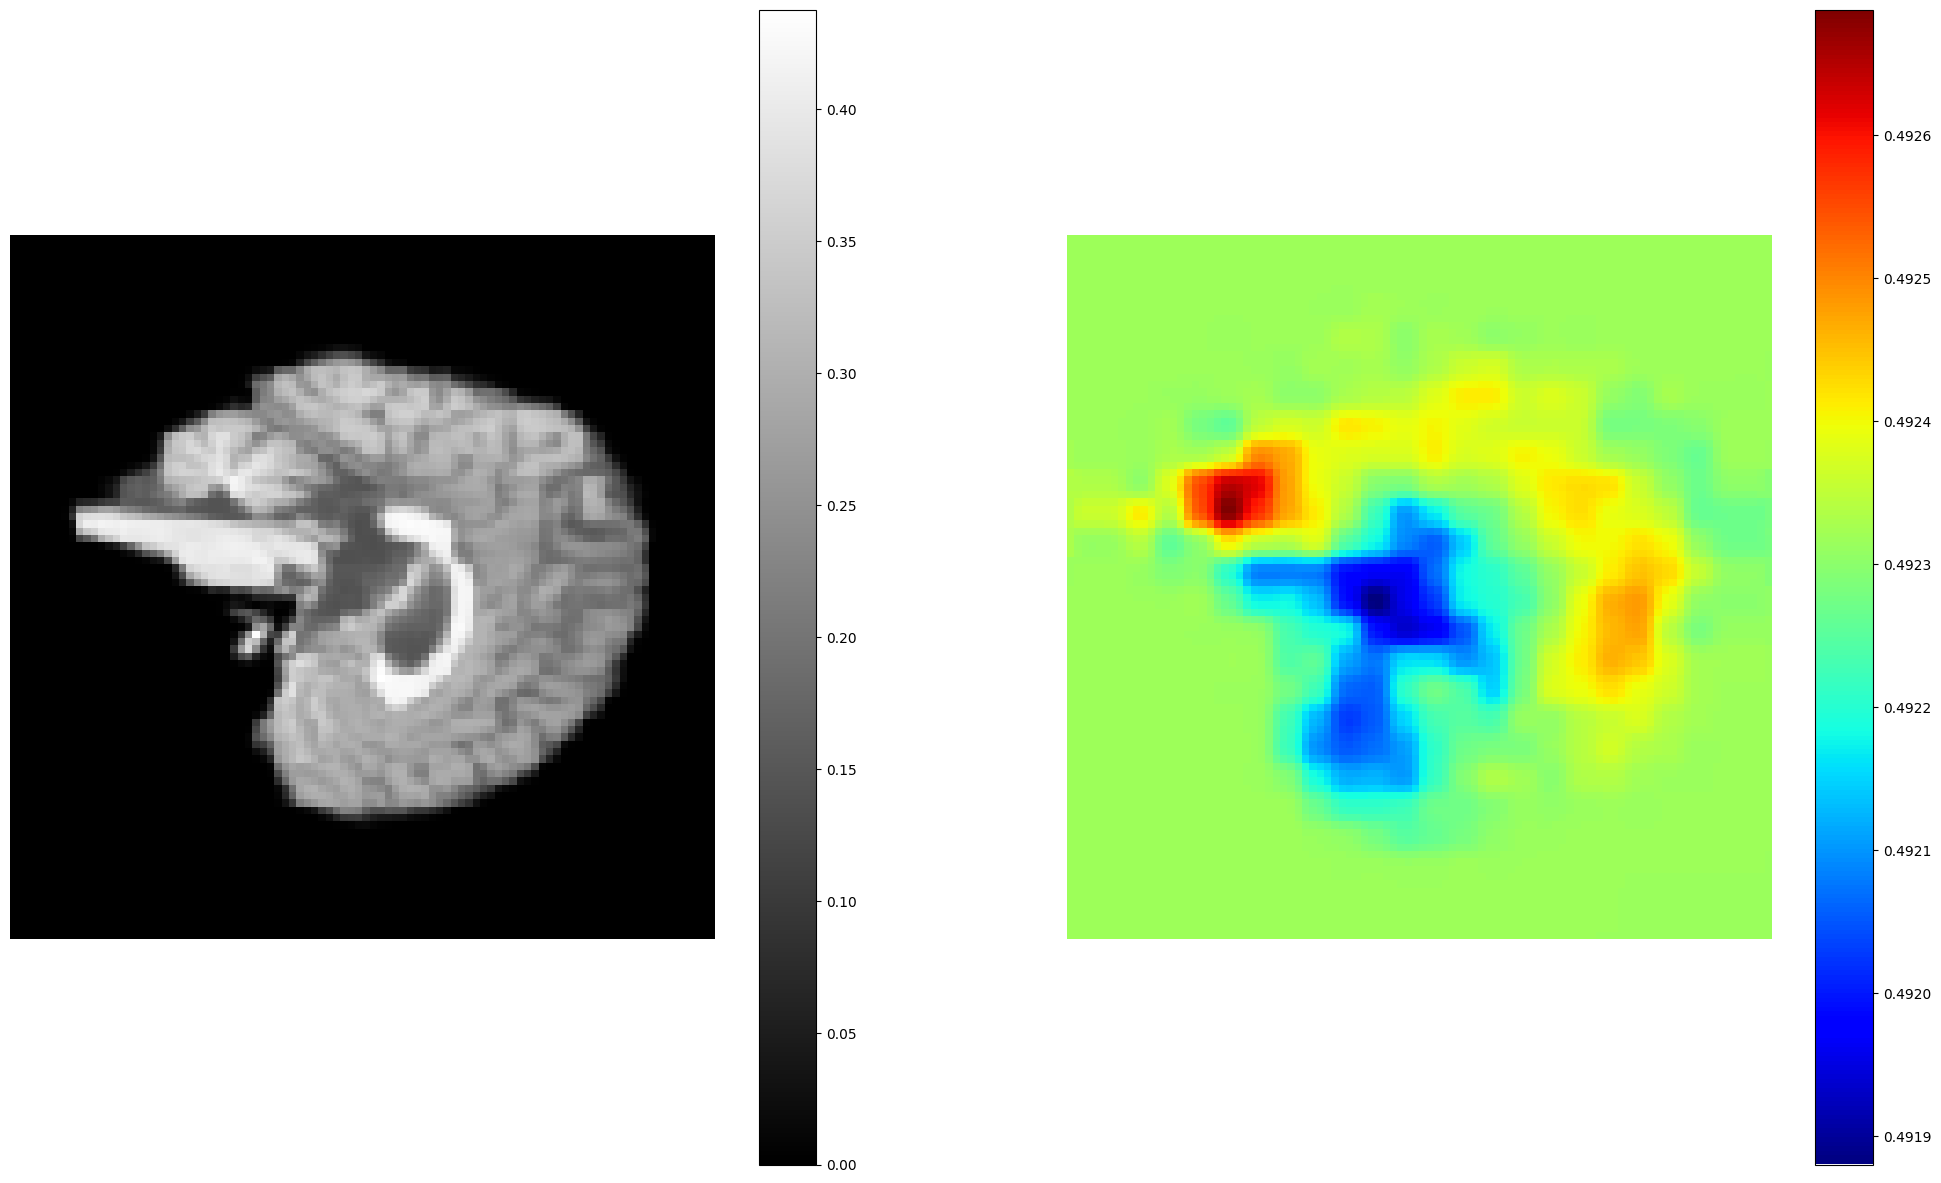

In [11]:
# Get the occlusion sensitivity map
occ_sens = monai.visualize.OcclusionSensitivity(nn_module=model, mask_size=12, n_batch=10)
# Only get a single slice to save time.
# For the other dimensions (channel, width, height), use
# -1 to use 0 and img.shape[x]-1 for min and max, respectively
depth_slice = img.shape[2] // 2
occ_sens_b_box = [depth_slice - 1, depth_slice, -1, -1, -1, -1]

occ_result, _ = occ_sens(x=img, b_box=occ_sens_b_box)
occ_result = occ_result[0, label.argmax().item()][None]

fig, axes = plt.subplots(1, 2, figsize=(25, 15), facecolor="white")

for i, im in enumerate([img[:, :, depth_slice, ...], occ_result]):
    cmap = "gray" if i == 0 else "jet"
    ax = axes[i]
    im_show = ax.imshow(np.squeeze(im[0][0].detach().cpu()), cmap=cmap)
    ax.axis("off")
    fig.colorbar(im_show, ax=ax)